In [1]:
%load_ext autoreload
%autoreload 2

# Outline

This notebook allows to analyse results from Gym1. There are two versions of the analysis: single processing or multi processing.

Here are the available sections
- [Analyse - Singleprocessing](#single)
- [Analyse - Multiprocessing](#multi)

In [2]:
import gym
import json
import os
import gym_sted
import pfrl
import torch
import sys
import pandas
import random
import pickle
import logging
import functools
import numpy

from tqdm.auto import trange, tqdm
from matplotlib import pyplot
from collections import defaultdict
from skimage import io

while "../.." in sys.path:
    sys.path.remove("../..")
sys.path.insert(0, "../..")
from src import models, WrapPyTorch

from gym_sted.envs.sted_env import action_spaces, scales_dict, bounds_dict

# Defines constants
PATH = "../../data"
PHY_REACTS = {
    "low-bleach" : gym_sted.defaults.FLUO["phy_react"],
    "mid-bleach" : {488: 0.5e-7 + 3 * 0.25e-7, 575: 50.0e-11 + 3 * 25.0e-11},
    "high-bleach" : {488: 0.5e-7 + 10 * 0.25e-7, 575: 50.0e-11 + 10 * 25.0e-11},
}
OBJS_YLIM = {
    "Resolution" : (0, 250),
    "Bleach" : (0, 1),
    "SNR" : (0, 2)
}

## Utilitaries

In [3]:
def sliding_window(x, kernel_size):
    """
    Computes a sliding window average over the specified data
    
    :param x: A `numpy.ndarray` of the data
    :param kernel_size: An `int` of the size of the sliding window
    
    :returns : A `numpy.ndarray` of the averaged data
    """
    if kernel_size < 2:
        return x
    window = windows.boxcar(kernel_size)
    window = window / window.sum()
    _x = numpy.pad(x, (kernel_size, kernel_size), mode="edge")
    return numpy.convolve(_x, window, mode="same")[kernel_size : -kernel_size]

def plot_score(df, x, y, shade_keys=None, smooth=1):
    """
    Plots the scores from a `pandas.DataFrame` using the provided 
    key
    
    :param df: A `pandas.DataFrame`
    :param key: A `str` of the desired key
    :param shade_keys: A `list` of keys to use as shade
    :param xlabel:
    
    :returns : A `matplotlib.Figure` of the created plot
               A `matplotlib.Axes` of the create plot
    """
    fig, ax = pyplot.subplots(figsize=(3,3))
    ax.plot(df[x], sliding_window(df[y], smooth))
    if isinstance(shade_keys, (tuple, list)):
        ax.fill_between(
            df[x], 
            sliding_window(df[y] - df[shade_keys[0]], smooth), 
            sliding_window(df[y] + df[shade_keys[1]], smooth), 
            alpha=0.3
        )
    elif isinstance(shade_keys, str):
        ax.fill_between(
            df[x], 
            sliding_window(df[y] - df[shade_keys], smooth), 
            sliding_window(df[y] + df[shade_keys], smooth), 
            alpha=0.3
        )
    ax.set(
        xlabel=x, ylabel=y
    )
    return fig, ax

def savefig(fig, ax, savepath, extension="pdf", save_white=False):
    """
    Utilitary function allowing to save the figure to 
    the savepath
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`  
    :param savepath: A `str` of the filename
    :param extension: A `str` of the extension of the file
    :param save_white: A `bool` wheter to save the figure in white version 
                       as well
    """
    fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True)
    if save_white:
        change_figax_color(fig, ax)
        fig.savefig(f"{savepath}_white.{extension}", bbox_inches="tight", transparent=True)
        
def change_figax_color(fig, ax):
    """
    Utilitary function allowing to change the figure and 
    ax color from black to white
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`    
    """
    def _change_ax(ax):
        ax.set_facecolor("none")
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('white')      
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        ax.title.set_color("white")
        
        # For line plots
        for line in ax.get_lines():
            if line.get_color() in ["#000000", "000000", "black"]:
                line.set_color("white")    

        # For scatter plots
        for collection in ax.collections:
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_facecolors()]
            collection.set_facecolors(new_colors)
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_edgecolors()]   
            collection.set_edgecolors(new_colors)

        # For hist plots
        for patch in ax.patches:
            c = patch.get_facecolor()
            if matplotlib.colors.to_hex(c) == "#000000":
                patch.set_color("white")        
        
    # Change figure background
    fig.patch.set_facecolor("none")
    
    # Changes colorbars if any
    for ax in fig.axes:
        _change_ax(ax.axes)

## Plotting

In [4]:
def plot_avg_reward(episode_stats, **kwargs):
    """
    Plots the average cummulated reward for all repetitions 
    
    :param episode_stats: A `list` of all episodes statistics
    
    :returns : A `matplotlib.Figure`
               A `matplotlib.Axes`
    """
    values = [sum([info["reward"] for info in infos]) for infos in episode_stats]
    fig, ax = pyplot.subplots(figsize=(3,3))
    ax.violinplot(values)
    ax.set(
        title="Average reward", **kwargs
    )
    return fig, ax

def plot_objs_evolution(episode_stats, obj_names=["Resolution", "Bleach", "SNR"]):
    """
    Plots the evolution of each objectives during an episode. The evolution 
    is averaged across the repetitions
    
    :param episode_stats: A `list` of all episodes statistics
    :param obj_names: A `list` of corresponding objective names
    
    :returns : A `dict` of all the created figure
    """
    values = [[info["mo_objs"] for info in infos] for infos in episode_stats]
    
    # Average over repetitions
    means = numpy.mean(values, axis=0)
    stds = numpy.std(values, axis=0)
    
    figaxes = {}
    for i, (key, mean, std) in enumerate(zip(obj_names, means.T, stds.T)):    
        fig, ax = pyplot.subplots(figsize=(3,3))
        x = numpy.arange(len(mean))
        ax.plot(x, mean, label=key)
        ax.fill_between(x, mean - std, mean + std, alpha=0.3)        
        ax.set(
            ylim=OBJS_YLIM[key], ylabel=key
        )
        figaxes[key] = (fig, ax)
    return figaxes

def plot_actions_evolution(episode_stats, normalize=True, action_names=["p_sted", "p_ex", "pdt"]):
    """
    Plots the evolution of each actions during an episode. The evolution 
    is averaged across the repetitions
    
    :param episode_stats: A `list` of all episodes statistics
    :param obj_names: A `list` of corresponding objective names
    
    :returns : A `dict` of all the created figure    
    """
    values = [[info["action"] for info in infos] for infos in episode_stats]
    
    # Average over repetitions
    means = numpy.mean(values, axis=0)
    stds = numpy.std(values, axis=0)    
    
    figaxes = {}
    for i, (key, mean, std) in enumerate(zip(action_names, means.T, stds.T)):    
        fig, ax = pyplot.subplots(figsize=(3,3))
        x = numpy.arange(len(mean))
        
        if normalize:
            mean = (mean - action_spaces[key]["low"]) / (action_spaces[key]["high"] - action_spaces[key]["low"])
            std = (std - action_spaces[key]["low"]) / (action_spaces[key]["high"] - action_spaces[key]["low"])
            
        ax.plot(x, mean, label=key)
        ax.fill_between(x, mean - std, mean + std, alpha=0.3)        
        ax.set(
            ylabel=key, ylim=(0, 1) if normalize else None
        )
        figaxes[key] = (fig, ax)
    return figaxes    
    
def show_acquire_images(episode_stats, num_examples=3):
    """
    Shows example of acquired images across an episode
    
    :param episode_stats: A `list` of all episodes statistics
    :param num_examples: An `int` of the number of examples to retreive
    
    :returns : A `list` of examples where each example contains {conf1, sted_image, conf2}
    """
    out = []
    choices = numpy.random.choice(len(episode_stats), size=min(len(episode_stats), num_examples), replace=False)
    for choice in choices:
        conf1_images = numpy.concatenate([info["conf1"] for info in episode_stats[choice]], axis=1)
        sted_images = numpy.concatenate([info["sted_image"] for info in episode_stats[choice]], axis=1)   
        conf2_images = numpy.concatenate([info["conf2"] for info in episode_stats[choice]], axis=1)
        out.append({
            "conf1" : conf1_images,
            "sted_image" : sted_images, 
            "conf2" : conf2_images
        })
    return out

def plot_avg_action(episode_stats):
    values = [stats["info"][0]["action"] for stats in episode_stats]
    values = numpy.array(values)
    
    fig, ax = pyplot.subplots(figsize=(3,3))
    for i, (key, value) in enumerate(zip(env.actions, values.T)):    
        value = (value - action_spaces[key]["low"]) / (action_spaces[key]["high"] - action_spaces[key]["low"])
        ax.violinplot(value, positions=[i])
    ax.set(
        ylim=(0, 1), title="Actions",
        xticks=(numpy.arange(values.shape[-1])), xticklabels=(env.actions)        
    )
    return fig, ax

def plot_avg_multiaction(episode_stats):
    values = [numpy.array([step["action"] for step in stats["info"]]) for stats in episode_stats]

    out = {"imaging-action" : []}
    for i, key in enumerate(env.actions):
        fig, ax = pyplot.subplots(figsize=(3,3))
        for value in values:
            value = (value[:, i] - action_spaces[key]["low"]) / (action_spaces[key]["high"] - action_spaces[key]["low"])
            ax.plot(value, alpha=0.3, color="black", label=key)
            ax.scatter(len(value) - 1, value[-1], marker="*", color="black")
        ax.set(
            ylim=(0, 1), title="Imaging action",
            xlabel="Steps", ylabel=key
        )
        out["imaging-action"].append((fig, ax))
    
    fig, ax = pyplot.subplots(figsize=(3,3))
    for value in values:
        value = numpy.clip(value[:, -1].astype(int) - 1, 0, 2)
        index = numpy.argmax(value == 1)
        where = value == 1
        where[index] = False
        value[where] = 0
        value[-1] = 2
        ax.plot(value, color="black", alpha=0.3)
    ax.set(
        ylim=(0, 2), title="Main action",
        xlabel="Steps"
    )
    out["main-action"] = (fig, ax)    
    
    return out

def plot_last_image(episode_stats):
    """
    Plots the last acquired image across all episodes
    """
    out = {}
    
    images = [stats["info"][-1]["conf1"] for stats in episode_stats]
    fig, axes = pyplot.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
    for ax, image in zip(axes.ravel(), images):
        ax.imshow(image, cmap="hot", vmin=0, vmax=1000)
    out["conf1"] = (fig, axes)
        
    images = [stats["info"][-1]["sted_image"] for stats in episode_stats]
    fig, axes = pyplot.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
    vmax = max([img.max() for img in images])
    for ax, image in zip(axes.ravel(), images):
        ax.imshow(image, cmap="hot", vmin=0, vmax=vmax) 
    out["sted_image"] = (fig, axes)        
        
    images = [stats["info"][-1]["conf2"] for stats in episode_stats]
    fig, axes = pyplot.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
    for ax, image in zip(axes.ravel(), images):
        ax.imshow(image, cmap="hot", vmin=0, vmax=1000)                
    out["conf2"] = (fig, axes)            
    return out

<a id="single"></a>
# Analyse Results - Single Process

In [ ]:
model_name = "20210901-092428_f62b76d6"
os.makedirs(os.path.join(PATH, model_name, "panels"), exist_ok=True)
os.makedirs(os.path.join(PATH, model_name, "eval"), exist_ok=True)

args = json.load(open(os.path.join(PATH, model_name, "args.txt"), "r"))
print(args)
def make_env(test):
    # Use different random seeds for train and test envs
    env_seed = 42
    env = gym.make(args["env"])
    # Use different random seeds for train and test envs
    env.seed(env_seed)
    # Converts the openAI Gym to PyTorch tensor shape
    env = WrapPyTorch(env)
    # Normalize the action space
    env = pfrl.wrappers.NormalizeActionSpace(env)
    return env

env = make_env(True)
timestep_limit = env.spec.max_episode_steps
obs_space = env.observation_space
action_space = env.action_space

policy = models.Policy2(action_size=action_space.shape[0], obs_space=obs_space)
vf = models.ValueFunction2(obs_space=obs_space)
model = pfrl.nn.Branched(policy, vf)

opt = torch.optim.Adam(model.parameters(), lr=args["lr"])

agent = pfrl.agents.PPO(
    model,
    opt,
    gpu=None,
    minibatch_size=args["batchsize"],
    max_grad_norm=1.0,
    update_interval=100
)
agent.load(os.path.join(PATH, model_name, "best"))
print(agent)

df = pandas.read_csv(os.path.join(PATH, model_name, "scores.txt"), sep="\t")
display(df.head())

smoothing_factor = 0
fig, ax = plot_score(df, "steps", "mean", shade_keys="stdev", smooth=smoothing_factor)
savefig(fig, ax, os.path.join(PATH, model_name, "panels", "mean_reward"), save_white=True)

pyplot.show()

In [ ]:
episode_count = 10
render, done = False, False

episode_stats = defaultdict(list)
for key, phy_react in PHY_REACTS.items():
    with agent.eval_mode():
        for i in trange(episode_count, desc=key, leave=False):
            observation = env.reset()

            # Sets the microscope bleach constant to default values
            env.microscope.fluo.phy_react = phy_react
    #         env.synapse_generator = gym_sted.utils.SynapseGenerator(mode="rand", seed=None, molecules=1)
    #         env.microscope.fluo.phy_react = {
    #             488: 0.5e-7 + 3 * 0.25e-7,
    #             575: 50.0e-11 + 3 * 25.0e-11
    #         }

            timestep, episode_len, cum_rewards = 0, 0, 0
            max_episode_len = env.spec.max_episode_steps

            stats = [] 
            while True:
                action = agent.act(observation)

                observation, reward, done, info = env.step(action)
                reset = done or episode_len == max_episode_len or info.get("needs_reset", False)
                agent.observe(observation, reward, done, reset)

                stats.append(info)

                if render:
                    env.render(info)
                if done:
                    break

                episode_len += 1

            episode_stats[key].append(stats)

In [ ]:
# Save results
pickle.dump(episode_stats, open(os.path.join(PATH, model_name, "eval", "stats.pkl"), "wb"))

## Plot results

In [ ]:
for bleach in PHY_REACTS.keys():

    fig, ax = plot_avg_reward(episode_stats[bleach])
    savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_avg_reward"), save_white=True)

    # fig, ax = plot_avg_rewards(episode_stats)
    # savefig(fig, ax, os.path.join(PATH, model_name, "panels", "avg_rewards"), save_white=True)

    # fig, ax = plot_avg_action(episode_stats)
    # savefig(fig, ax, os.path.join(PATH, model_name, "panels", "avg_action"), save_white=True)

    figaxes = plot_avg_multiaction(episode_stats[bleach])
    for key, figaxes in figaxes.items():
        if isinstance(figaxes, tuple):
            fig, ax = figaxes
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_avg_multiaction_{key}"), save_white=True)
        else:
            for action_name, (fig, ax) in zip(env.actions, figaxes):
                savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_avg_multiaction_{key}_{action_name}"), save_white=True)            

    figaxes = plot_last_image(episode_stats[bleach])
    for key, figaxes in figaxes.items():
        if isinstance(figaxes, tuple):
            fig, ax = figaxes
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_last-images_{key}"), save_white=True)
        else:
            for action_name, (fig, ax) in zip(env.actions, figaxes):
                savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_last-images_{key}_{action_name}"), save_white=True)            

    pyplot.show()

<a id="multi"></a>
# Analyse results - Multiprocessing

In [ ]:
def _batch_run_episodes_record(
    env,
    agent,
    n_steps,
    n_episodes,
    max_episode_len=None,
    logger=None,
):
    """Run multiple episodes and return returns in a batch manner."""
    assert (n_steps is None) != (n_episodes is None)

    logger = logger or logging.getLogger(__name__)
    num_envs = env.num_envs
    episode_returns = dict()
    episode_lengths = dict()
    episode_infos = dict()
    episode_indices = numpy.zeros(num_envs, dtype="i")
    episode_idx = 0
    for i in range(num_envs):
        episode_indices[i] = episode_idx
        episode_idx += 1
    episode_r = numpy.zeros(num_envs, dtype=numpy.float64)
    episode_len = numpy.zeros(num_envs, dtype="i")
    episode_info = [[] for _ in range(num_envs)]

    obss = env.reset()
    rs = numpy.zeros(num_envs, dtype="f")

    termination_conditions = False
    timestep = 0
    while True:
        
        # a_t
        actions = agent.batch_act(obss)
        timestep += 1
        # o_{t+1}, r_{t+1}
        obss, rs, dones, infos = env.step(actions)
        episode_r += rs
        episode_len += 1
        for i, info in enumerate(infos):
            episode_info[i].append(info)

        # Compute mask for done and reset
        if max_episode_len is None:
            resets = numpy.zeros(num_envs, dtype=bool)
        else:
            resets = episode_len == max_episode_len
        resets = numpy.logical_or(
            resets, [info.get("needs_reset", False) for info in infos]
        )

        # Make mask. 0 if done/reset, 1 if pass
        end = numpy.logical_or(resets, dones)
        not_end = numpy.logical_not(end)

        for index in range(len(end)):
            if end[index]:
                episode_returns[episode_indices[index]] = episode_r[index]
                episode_lengths[episode_indices[index]] = episode_len[index]
                episode_infos[episode_indices[index]] = episode_info[index]
                # Give the new episode an a new episode index
                episode_indices[index] = episode_idx
                episode_idx += 1

        # Resets done episode
        episode_r[end] = 0
        episode_len[end] = 0
        for index in range(len(end)):
            if end[index]:
                episode_info[index] = []

        # find first unfinished episode
        first_unfinished_episode = 0
        while first_unfinished_episode in episode_returns:
            first_unfinished_episode += 1

        # Check for termination conditions
        eval_episode_returns = []
        eval_episode_lens = []
        eval_episode_infos = []
        if n_steps is not None:
            total_time = 0
            for index in range(first_unfinished_episode):
                total_time += episode_lengths[index]
                # If you will run over allocated steps, quit
                if total_time > n_steps:
                    break
                else:
                    eval_episode_returns.append(episode_returns[index])
                    eval_episode_lens.append(episode_lengths[index])
                    eval_episode_infos.append(episode_infos[index])
            termination_conditions = total_time >= n_steps
            if not termination_conditions:
                unfinished_index = numpy.where(
                    episode_indices == first_unfinished_episode
                )[0]
                if total_time + episode_len[unfinished_index] >= n_steps:
                    termination_conditions = True
                    if first_unfinished_episode == 0:
                        eval_episode_returns.append(episode_r[unfinished_index])
                        eval_episode_lens.append(episode_len[unfinished_index])
                        eval_episode_infos.append(episode_infos[index])
        else:
            termination_conditions = first_unfinished_episode >= n_episodes
            if termination_conditions:
                # Get the first n completed episodes
                for index in range(n_episodes):
                    eval_episode_returns.append(episode_returns[index])
                    eval_episode_lens.append(episode_lengths[index])
                    eval_episode_infos.append(episode_infos[index])                    

        if termination_conditions:
            # If this is the last step, make sure the agent observes reset=True
            resets.fill(True)

        # Agent observes the consequences.
        agent.batch_observe(obss, rs, dones, resets)

        if termination_conditions:
            break
        else:
            obss = env.reset(not_end)

    for i, (epi_len, epi_ret) in enumerate(
        zip(eval_episode_lens, eval_episode_returns)
    ):
        logger.info("evaluation episode %s length: %s R: %s", i, epi_len, epi_ret)
    scores = [float(r) for r in eval_episode_returns]
    lengths = [float(ln) for ln in eval_episode_lens]
    infos = [info for info in eval_episode_infos]
    return scores, lengths, infos


def batch_run_evaluation_episodes_record_actions(
    env,
    agent,
    n_steps,
    n_episodes,
    max_episode_len=None,
    logger=None,
):
    """Run multiple evaluation episodes and return returns in a batch manner.

    Args:
        env (VectorEnv): Environment used for evaluation.
        agent (Agent): Agent to evaluate.
        n_steps (int): Number of total timesteps to evaluate the agent.
        n_episodes (int): Number of evaluation runs.
        max_episode_len (int or None): If specified, episodes
            longer than this value will be truncated.
        logger (Logger or None): If specified, the given Logger
            object will be used for logging results. If not
            specified, the default logger of this module will
            be used.

    Returns:
        List of returns of evaluation runs.
    """
    with agent.eval_mode():
        return _batch_run_episodes_record(
            env=env,
            agent=agent,
            n_steps=n_steps,
            n_episodes=n_episodes,
            max_episode_len=max_episode_len,
            logger=logger,
        )
    
model_name = "20210901-090737_aca16c29"
os.makedirs(os.path.join(PATH, model_name, "panels"), exist_ok=True)
os.makedirs(os.path.join(PATH, model_name, "eval"), exist_ok=True)

args = json.load(open(os.path.join(PATH, model_name, "args.txt"), "r"))
args["env"] = "gym_sted:MOSTEDRankingWithArticulation-easy-v4"
NUM_ENVS = 5

process_seeds = numpy.arange(NUM_ENVS) + 42
def make_env(idx, test, **kwargs):
    # Use different random seeds for train and test envs
    process_seed = int(process_seeds[idx])
    env_seed = 2 ** 32 - 1 - process_seed if test else process_seed
    env = gym.make(args["env"])
    # Use different random seeds for train and test envs
    env.seed(env_seed)
    # Converts the openAI Gym to PyTorch tensor shape
    env = WrapPyTorch(env)
    # Normalize the action space
    env = pfrl.wrappers.NormalizeActionSpace(env)
    
    if "phy_react" in kwargs:
        env.microscope.fluo.phy_react = kwargs.get("phy_react")
    return env

def make_batch_env(test, **kwargs):
    vec_env = pfrl.envs.MultiprocessVectorEnv(
        [
            functools.partial(make_env, idx, test, **kwargs)
            for idx, env in enumerate(range(NUM_ENVS))
        ]
    )
    # vec_env = pfrl.wrappers.VectorFrameStack(vec_env, 4)
    return vec_env

env = make_env(0, True)
timestep_limit = env.spec.max_episode_steps
obs_space = env.observation_space
action_space = env.action_space

# Creates the agent 
policy = models.PolicyWithSideAction(action_size=action_space.shape[0], obs_space=obs_space)
vf = models.ValueFunction2(obs_space=obs_space)
model = pfrl.nn.Branched(policy, vf)
opt = torch.optim.Adam(model.parameters(), lr=args["lr"])
agent = pfrl.agents.PPO(
    model,
    opt,
    gpu=0,
    minibatch_size=args["batchsize"],
    max_grad_norm=1.0,
    update_interval=512
)
agent.load(os.path.join(PATH, model_name, "best"))

all_records = {}
for key, phy_react in tqdm(PHY_REACTS.items()):
    # Creates the batch envs
    env = make_batch_env(test=True, phy_react=phy_react)
    scores, lengths, records = batch_run_evaluation_episodes_record_actions(env, agent, n_steps=None, n_episodes=100)
    all_records[key] = records


/opt/anaconda3/envs/gym-sted/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
pickle.dump(all_records, open(os.path.join(PATH, model_name, "eval", "stats.pkl"), "wb"))

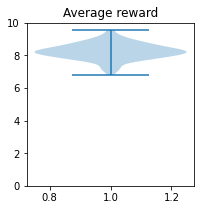

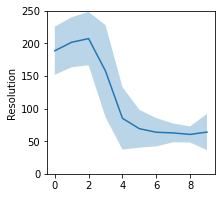

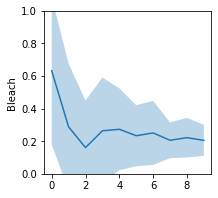

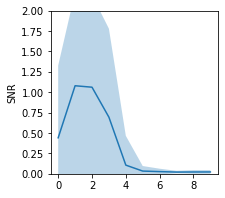

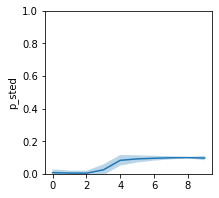

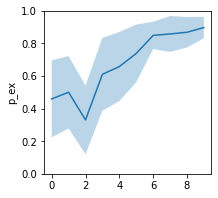

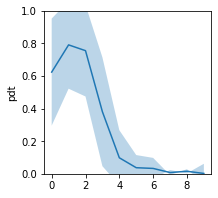

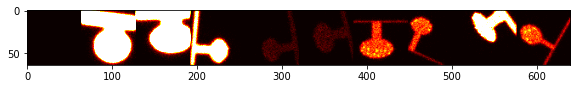

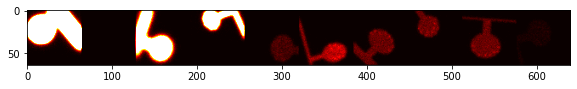

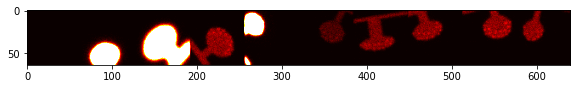

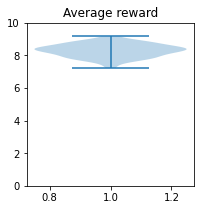

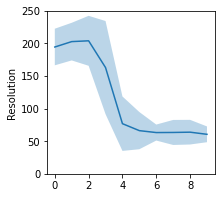

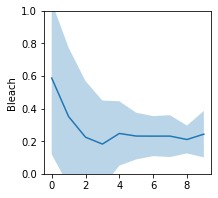

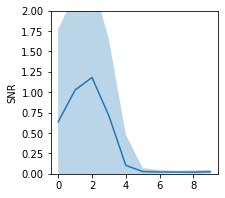

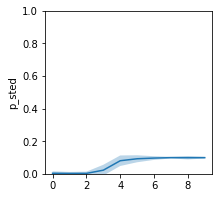

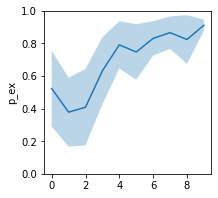

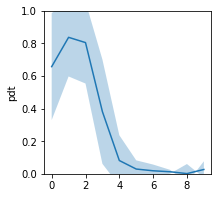

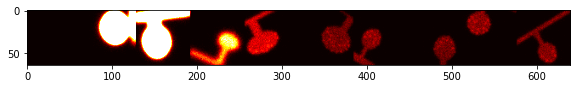

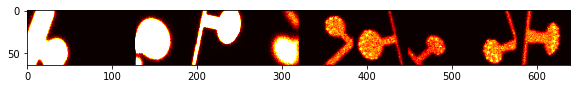

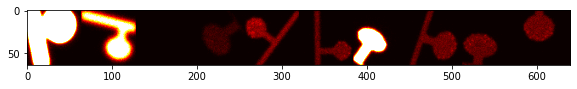

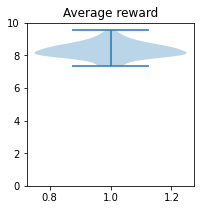

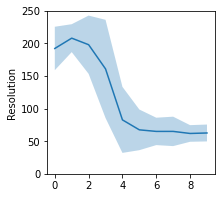

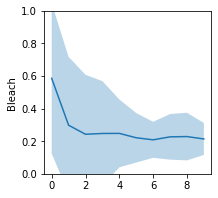

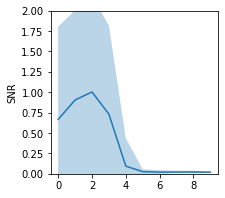

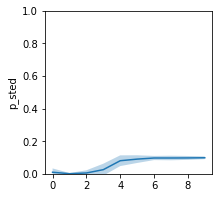

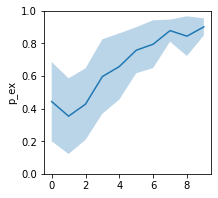

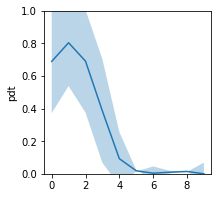

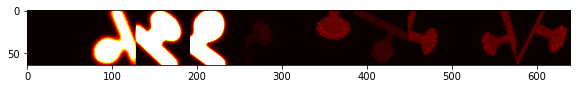

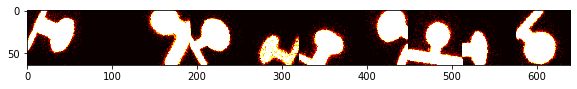

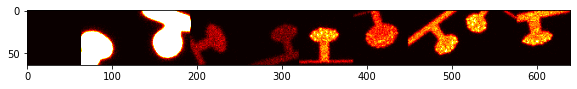

In [8]:
SAVE = False
for bleach in PHY_REACTS.keys():

    fig, ax = plot_avg_reward(all_records[bleach], ylim=(0, 10))
    if SAVE:
        savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_avg_reward"), save_white=True)

    figaxes = plot_objs_evolution(all_records[bleach])
    if SAVE:
        savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_avg_objs_evolution"), save_white=True)

    figaxes = plot_actions_evolution(all_records[bleach])
    if SAVE:
        savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_avg_actions_evolution"), save_white=True)    
        
    example_images = show_acquire_images(all_records[bleach])
    for example in example_images:
        fig, ax = pyplot.subplots(figsize=(10, 1))
        ax.imshow(example["sted_image"], vmin=0, vmax=0.03 * example["sted_image"].max(), cmap="hot")
    if SAVE:
        for i, example in enumerate(example_images):
            io.imsave(os.path.join(PATH, model_name, "panels", f"{bleach}_example-{i}_sted.tif"), example["sted_image"].astype(numpy.uint16), check_contrast=False)

        
#     figaxes = plot_last_image(all_records[bleach])
#     if SAVE:
#         for key, figaxes in figaxes.items():
#             if isinstance(figaxes, tuple):
#                 fig, ax = figaxes
#                 savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_last-images_{key}"), save_white=True)
#             else:
#                 for action_name, (fig, ax) in zip(env.actions, figaxes):
#                     savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_last-images_{key}_{action_name}"), save_white=True)            

    pyplot.show()